In [1]:
# Import necessary libraries
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from anndata import AnnData
import sys
import time

# Add the src directory to the path
sys.path.append('joint/src')

# Import our custom modules
from data import prepare_data
from model import joint_model
from eval import evaluate_imputation
from utils import *

# Set random seeds for reproducibility
np.random.seed(10042)
torch.manual_seed(10042)

# Check if CUDA is available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
# Create output directory
output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Load data
# Replace these paths with your actual data paths
vi_path = "/home/pjiangag/main/mm/siid/BRCA/cast_output/visium_aligned.h5ad"
xe_path = "/home/pjiangag/main/mm/siid/BRCA/cast_output/xenium_aligned.h5ad"

print(f"Loading data from {vi_path} and {xe_path}")
vi = sc.read_h5ad(vi_path)
xe = sc.read_h5ad(xe_path)

print(f"Visium data shape: {vi.shape}")
print(f"Xenium data shape: {xe.shape}")

Loading data from /home/pjiangag/main/mm/siid/BRCA/cast_output/visium_aligned.h5ad and /home/pjiangag/main/mm/siid/BRCA/cast_output/xenium_aligned.h5ad
Visium data shape: (4992, 18085)
Xenium data shape: (167780, 313)


In [4]:
# Examine the data
print("Visium data:")
print(vi)
print("\nXenium data:")
print(xe)

# Check if spatial coordinates exist
print("\nVisium spatial coordinates shape:", vi.obsm['spatial'].shape if 'spatial' in vi.obsm else "Not found")
print("Xenium spatial coordinates shape:", xe.obsm['spatial'].shape if 'spatial' in xe.obsm else "Not found")

Visium data:
AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial'

Xenium data:
AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

Visium spatial coordinates shape: (4992, 2)
Xenium spatial coordinates shape: (167780, 2)


In [5]:
# Find intersection of genes and randomly select 1/10 as holdout genes
all_genes = list(set(vi.var_names).intersection(set(xe.var_names)))
print(f"Number of genes in intersection: {len(all_genes)}")

# Set random seed for reproducibility
np.random.seed(10042)

# Randomly select 1/10 of intersection genes as holdout genes
n_holdout = max(1, int(len(all_genes) / 10))
holdout_genes = np.random.choice(all_genes, size=n_holdout, replace=False).tolist()

print(f"Randomly selected {len(holdout_genes)} holdout genes out of {len(all_genes)} intersection genes")
print(f"First 5 holdout genes: {holdout_genes[:5]}")

Number of genes in intersection: 307
Randomly selected 30 holdout genes out of 307 intersection genes
First 5 holdout genes: ['EDN1', 'KRT15', 'PIGR', 'ENAH', 'FAM107B']


In [6]:
# Prepare data
print(f"Preparing data with {len(holdout_genes)} holdout genes")
sorted_vi, sorted_xe = prepare_data(vi, xe, holdout_genes)

print(f"Processed Visium data shape: {sorted_vi.shape}")
print(f"Processed Xenium data shape: {sorted_xe.shape}")

# Save a copy of the original data for the holdout genes
holdout_xe = xe[:, holdout_genes].copy()
print(f"Holdout data shape: {holdout_xe.shape}")

Preparing data with 30 holdout genes
Processed Visium data shape: (4992, 307)
Processed Xenium data shape: (167780, 277)
Holdout data shape: (167780, 30)


In [7]:
# Define model parameters
hdim = 20  # Number of latent factors
ent_div = 500  # Entropy regularization denominator
lr = 1e-2  # Learning rate
epochs = 5000  # Reduced for testing, use 5000 for full training
k_neighbors_xenium = 40  # Number of neighbors for spatial graph
k_neighbors_visium = 20  # Number of neighbors for spatial graph
gcn_hidden_dim = 64  # Hidden dimension for GCN layers
gcn_layers = 2  # Number of GCN layers

In [8]:
# Initialize the joint model
print(f"Initializing model with {hdim} factors, {k_neighbors_xenium} neighbors, {gcn_layers} GCN layers")
model = joint_model(
    xe=sorted_xe,
    vi=sorted_vi,
    n_factors=hdim,
    device=device,
    adaptive_entropy=True,
    adaptive_entropy_denominator=ent_div,
    poisson_sum=True,
    add_entropy=True,
    k_neighbors_xenium=k_neighbors_xenium,
    k_neighbors_visium=k_neighbors_visium,
    gcn_hidden_dim=gcn_hidden_dim
)

Initializing model with 20 factors, 40 neighbors, 2 GCN layers


In [9]:
# Ensure all model parameters are on the correct device
for param in model.parameters():
    if param.device != torch.device(device):
        param.data = param.data.to(device)

# Also ensure edge indices are on the correct device
model.edge_index = model.edge_index.to(device)
model.v2x_edge_index = model.v2x_edge_index.to(device)

In [10]:
# Train the model
print(f"Training model for {epochs} epochs")
start_time = time.time()

results = model.train(
    num_epochs=epochs,
    lr=lr,
    print_freq=100,
    loss_type='poisson'
)

training_time = time.time() - start_time
print(f"Training finished in {training_time:.2f} seconds")

losses = results['losses']

Training model for 5000 epochs
Training the model with poisson loss
Epoch 0, Loss: 4722893824.0000, Xenium loss: 139941395.6890, Visium loss: 19494836.0000, Regularization: 2.9987, Entropy: -2.9957
New best loss: 4722893824.0000
Epoch 100, Loss: 4043187456.0000, Xenium loss: 119799347.2793, Visium loss: 16758392.0000, Regularization: 3.6975, Entropy: -3.6589
New best loss: 4043187456.0000
Epoch 200, Loss: 3829735936.0000, Xenium loss: 113479090.8674, Visium loss: 15729060.0000, Regularization: 4.5589, Entropy: -4.4691
New best loss: 3829735936.0000
Epoch 300, Loss: 3769831424.0000, Xenium loss: 111709586.6423, Visium loss: 15297402.0000, Regularization: 5.5885, Entropy: -5.4585
New best loss: 3769831424.0000
Epoch 400, Loss: 3751535104.0000, Xenium loss: 111169804.6398, Visium loss: 15142991.0000, Regularization: 6.8250, Entropy: -6.6670
New best loss: 3751535104.0000
Epoch 500, Loss: 3744380416.0000, Xenium loss: 110958369.0124, Visium loss: 15094474.0000, Regularization: 8.3211, Entr

KeyboardInterrupt: 

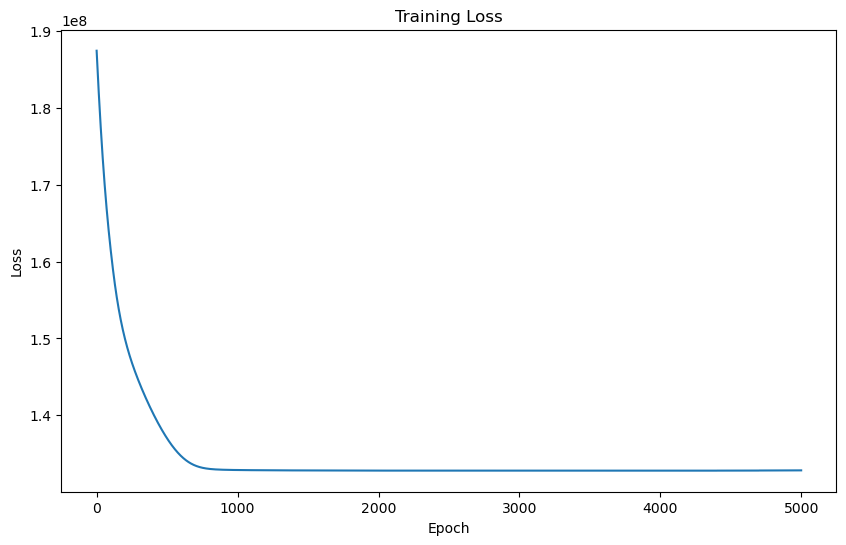

In [12]:
# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig(os.path.join(output_dir, 'loss_curve.png'))
plt.show()

In [ ]:
# Get predictions for holdout genes
print("Generating predictions")
model.eval()
with torch.no_grad():
    xenium_est = model.get_xenium_est().cpu().numpy()

# Create AnnData object with predictions
full_pred = AnnData(X=xenium_est, obs=sorted_xe.obs, var=sorted_vi.var)

# Extract predictions for holdout genes
imputed = full_pred[:, holdout_genes].copy()
print(f"Imputed data shape: {imputed.shape}")

Generating predictions
Imputed data shape: (167780, 30)


Evaluating predictions


Evaluation metrics:
  R²: 0.1662
  PCC: 0.4077
  SSIM: 0.0032
  RMSE: 1.0884
  JS: 7.8193
  NNZ: 0.4721
  Cell-wise R²: 0.2765
  Gene-wise R²: 0.0000
r2: 0.16624518845213784
pcc: 0.4077317416667938
ssim: 0.0032047966839608474
rmse: -1.0883637911130772
js: -7.819253921508789
nnz: 0.4721424439026406
cell_r2: 0.2764877573560901
gene_r2: 0.0


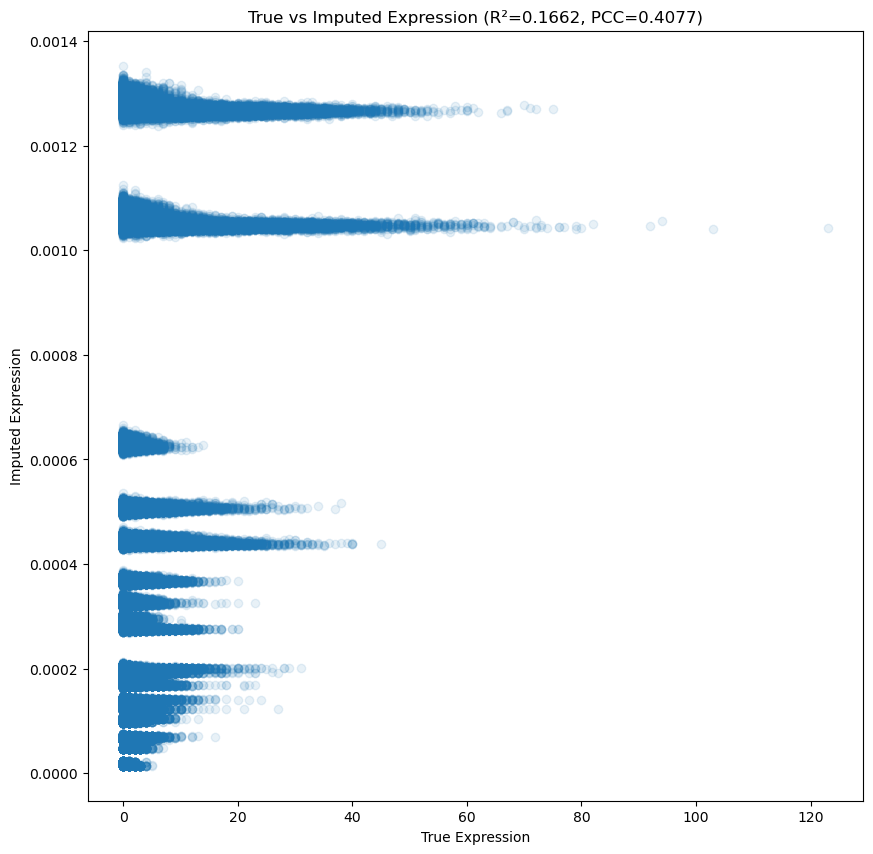

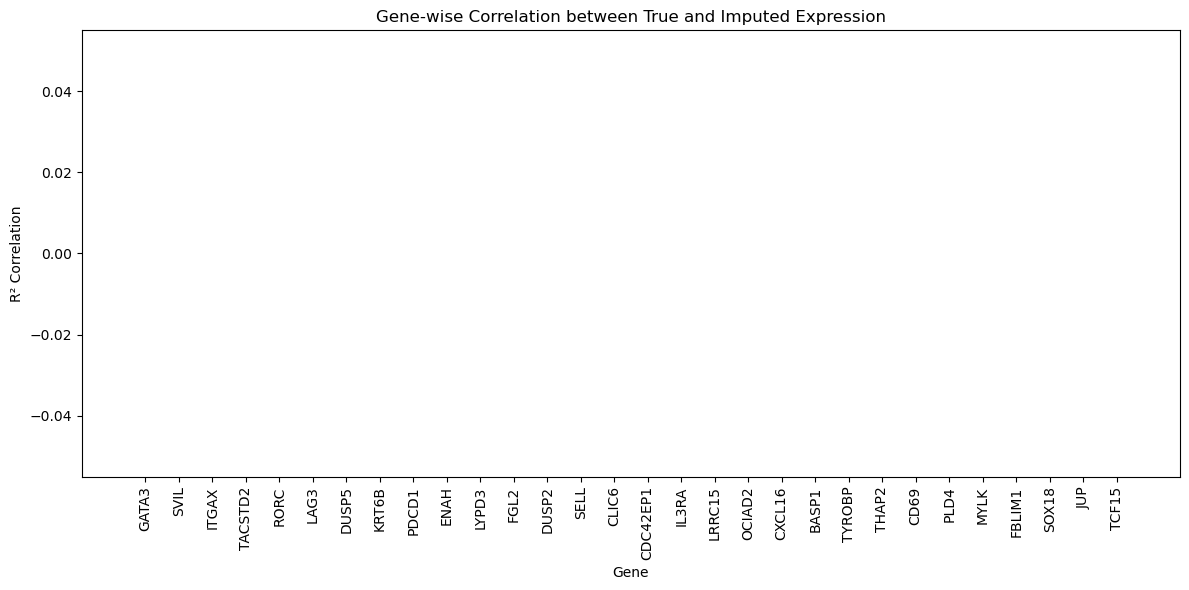

In [ ]:
# Evaluate predictions
print("Evaluating predictions")
metrics = evaluate_imputation(holdout_xe, imputed, output_dir)

# Print metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

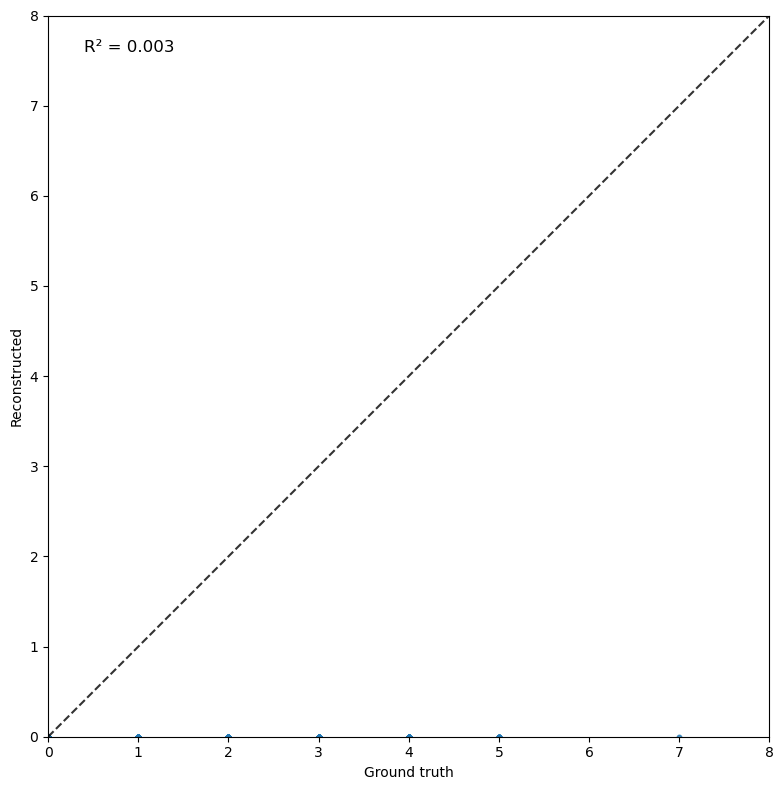

In [18]:
g = holdout_genes[3]

ground_truth = xe[:, g].X.toarray().flatten()
reconstructed = imputed[:, g].X.toarray().flatten()

# Create the plot
plt.figure(figsize=(8, 8))  # Makes a square figure

# Create scatter plot
plt.scatter(ground_truth, reconstructed, alpha=0.5, s=10)  # s is point size, alpha is transparency

# Add diagonal line
max_val = 8
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.8)  # k-- means black dashed line

# Customize axes
plt.xlabel('Ground truth')
plt.ylabel('Reconstructed')
plt.xlim(0, max_val)
plt.ylim(0, max_val)

# Make axes equal aspect ratio
plt.gca().set_aspect('equal')

# Optional: Add grid
# plt.grid(True, linestyle='--', alpha=0.3)

corr_matrix = np.corrcoef(ground_truth, reconstructed)
r2 = corr_matrix[0, 1]**2
# Add R² score text to plot
plt.text(0.05*max_val, 0.95*max_val, f'R² = {r2:.3f}', fontsize=12)

plt.tight_layout()
plt.show()

Factors shape: (167780, 20)
Loadings shape: (20, 307)


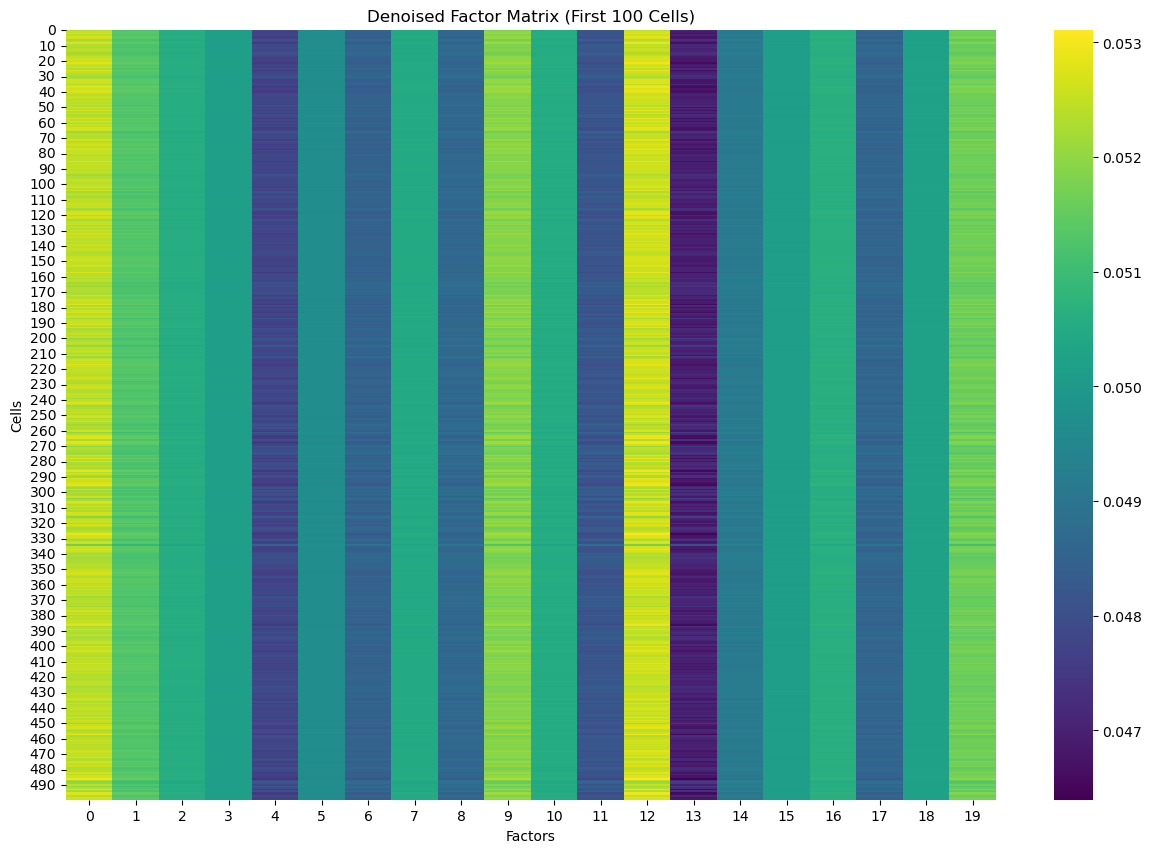

In [31]:
# Visualize factors
with torch.no_grad():
    factors = model.F_soft.cpu().numpy()
    loadings = model.W_soft.cpu().numpy()

print(f"Factors shape: {factors.shape}")
print(f"Loadings shape: {loadings.shape}")

plt.figure(figsize=(15, 10))
sns.heatmap(factors[:500, :], cmap='viridis')
plt.xlabel('Factors')
plt.ylabel('Cells')
plt.title('Denoised Factor Matrix (First 100 Cells)')
plt.savefig(os.path.join(output_dir, 'factor_heatmap.png'))
plt.show()

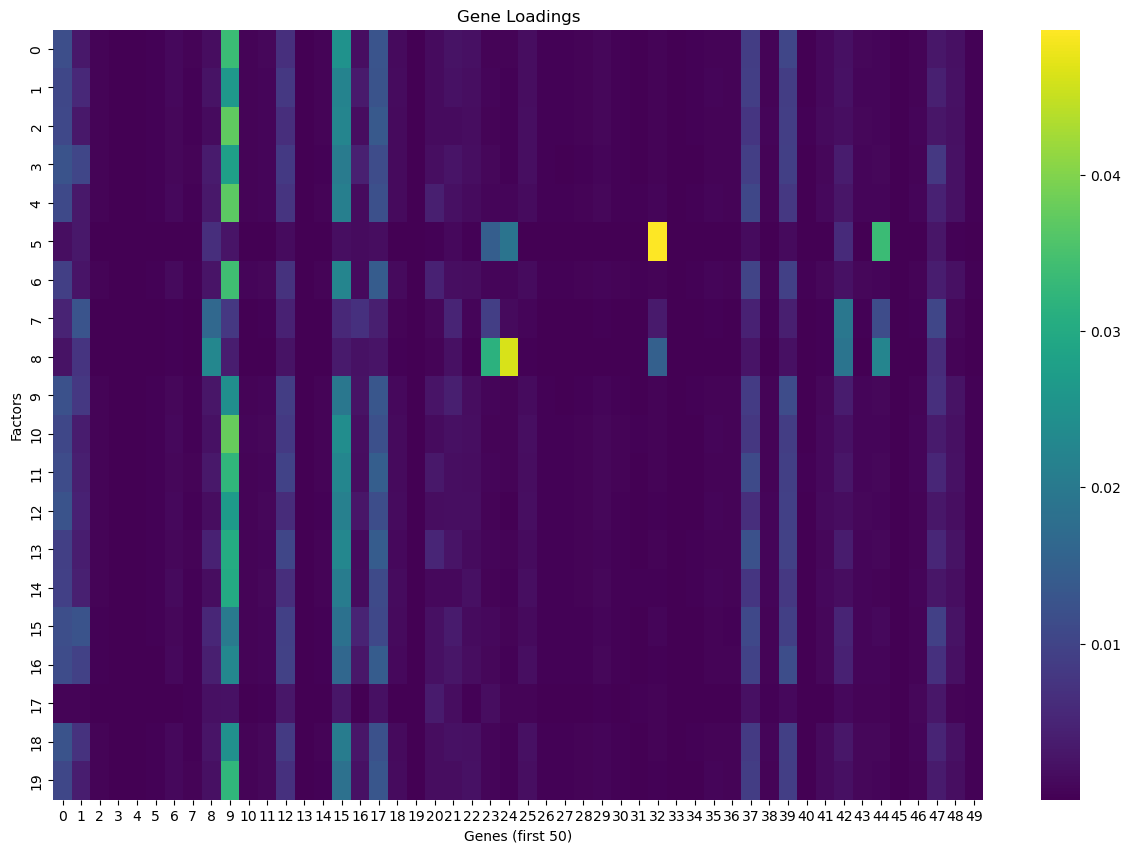

In [30]:
# Visualize loadings
plt.figure(figsize=(15, 10))
sns.heatmap(loadings[:, :50], cmap='viridis')
plt.xlabel('Genes (first 50)')
plt.ylabel('Factors')
plt.title('Gene Loadings')
plt.savefig(os.path.join(output_dir, 'loading_heatmap.png'))
plt.show()

In [ ]:
# Visualize spatial distribution of dominant factor
dominant_factor = np.argmax(factors, axis=1)

# Create a new AnnData object with the dominant factor
spatial_adata = AnnData(X=np.zeros((factors.shape[0], 1)))
spatial_adata.obs['dominant_factor'] = dominant_factor
spatial_adata.obsm['spatial'] = model.xe.obsm['spatial'].copy()

# Save for later visualization with scanpy
spatial_adata.write_h5ad(os.path.join(output_dir, 'spatial_factors.h5ad'))

# Basic spatial plot
plt.figure(figsize=(10, 10))
plt.scatter(
    spatial_adata.obsm['spatial'][:, 0],
    spatial_adata.obsm['spatial'][:, 1],
    c=dominant_factor,
    cmap='tab20',
    s=5,
    alpha=0.7
)
plt.title('Spatial Distribution of Dominant Factors')
plt.axis('equal')
plt.colorbar(label='Factor')
plt.savefig(os.path.join(output_dir, 'spatial_factors.png'))
plt.show()

In [ ]:
# Save results
print("Saving results")
save_results(model, imputed, losses, metrics, output_dir)
print(f"Results saved to {output_dir}")

In [ ]:
# Examine the imputed data vs. true data for a few genes
n_genes_to_plot = min(5, len(holdout_genes))
fig, axes = plt.subplots(n_genes_to_plot, 2, figsize=(15, 4*n_genes_to_plot))

for i in range(n_genes_to_plot):
    gene = holdout_genes[i]
    
    # True expression
    true_expr = holdout_xe[:, gene].X
    if not isinstance(true_expr, np.ndarray):
        true_expr = true_expr.toarray()
    true_expr = true_expr.flatten()
    
    # Imputed expression
    imputed_expr = imputed[:, gene].X
    if not isinstance(imputed_expr, np.ndarray):
        imputed_expr = imputed_expr.toarray()
    imputed_expr = imputed_expr.flatten()
    
    # Scatter plot
    axes[i, 0].scatter(true_expr, imputed_expr, alpha=0.5)
    axes[i, 0].set_xlabel('True Expression')
    axes[i, 0].set_ylabel('Imputed Expression')
    axes[i, 0].set_title(f'Gene: {gene}')
    
    # Calculate correlation
    corr, _ = pearsonr(true_expr, imputed_expr)
    axes[i, 0].text(0.05, 0.95, f'Pearson r: {corr:.4f}', transform=axes[i, 0].transAxes)
    
    # Spatial plot
    sc = axes[i, 1].scatter(
        xe.obsm['spatial'][:, 0],
        xe.obsm['spatial'][:, 1],
        c=imputed_expr,
        cmap='viridis',
        s=3,
        alpha=0.7
    )
    axes[i, 1].set_title(f'Spatial Distribution of Imputed {gene}')
    axes[i, 1].axis('equal')
    plt.colorbar(sc, ax=axes[i, 1])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'gene_comparisons.png'))
plt.show()